# Explore DSC output

**FIXME: temporarily broken due to unresolved `seed` problem.**

This tutorial is a continuation of the [5 Minutes Quick Start](5_Minutes.html). As a reminder here is the DSC script we've executed:

```
normal: normal.R
  n: 100
  $data: x
  $true_mean: 0

t: t.R
  n: 100
  df: 2
  $data: x
  $true_mean: 3

mean: mean.R
  x: $data
  $est_mean: y

median: median.R
  x: $data
  $est_mean: y

sq_err: sq.R
  a: $est_mean
  b: $true_mean
  $error: e

abs_err: abs.R
  a: $est_mean
  b: $true_mean
  $error: e 

DSC:
    define:
      simulate: normal, t
      analyze: mean, median
      score: abs_err, sq_err
    run: simulate * analyze * score
    exec_path: R
    output: dsc_result
```

## `dscrutils` and result query

Here we demonstrate extracting DSC benchmark metric `mse` for all scenarios, and evaluate 4 cases:

* Case 1: simulated from `rt` and analyzed by `mean`
* Case 2: simulated from `rnorm` and analyzed by `mean`
* Case 3: simulated from `rt` and analyzed by `median`
* Case 4: simulated from `rnorm` and analyzed by `median`

We use the R function `dscquery` provided by `dscrutils` package to extract data. This packages should have been installed as a result of running the DSC benchmark in the [previous tutorial](5_Minutes.html). Since this example is small enough, we will demonstrate loading all results to R and explore from there.

In [1]:
%cd ~/GIT/dsc2/vignettes/one_sample_location

/home/gaow/Documents/GIT/software/dsc2/vignettes/one_sample_location

In [2]:
dsc_dir = "dsc_result"
dat = dscrutils::dscquery(dsc_dir,
                          targets = c(paste("simulate",c("n","seed"),sep="."),
                                      "analyze", "score.error"))

Running shell command:
dsc-query dsc_result -o /tmp/Rtmp9l35Pv/dsc/query.csv --target simulate.n simulate.seed simulate.true_mean estimate mse.mse 
Loading dsc-query output from CSV file.
Reading DSC outputs:
 - mse.mse: extracted atomic values


In [3]:
dat

simulate,simulate_n,simulate_seed,simulate_true_mean,estimate,estimate.output,mse.mse
t,1000,1,0,median,normal_1_mean_1,1.356792e-04
t,1000,2,0,median,normal_2_mean_1,3.843843e-03
t,1000,3,0,median,normal_3_mean_1,4.091567e-05
t,1000,4,0,median,normal_4_mean_1,1.185285e-03
t,1000,5,0,median,normal_5_mean_1,3.027412e-04
t,1000,1,1,median,normal_6_mean_1,1.356792e-04
t,1000,2,1,median,normal_7_mean_1,3.843843e-03
t,1000,3,1,median,normal_8_mean_1,4.091567e-05
t,1000,4,1,median,normal_9_mean_1,1.185285e-03
t,1000,5,1,median,normal_10_mean_1,3.027412e-04


## Analyzing DSC results
Let's focus on comparing results of Case 1 vs Case 3. 

In [4]:
dat1 = subset(dat, simulate == "t")[,c('estimate','mse.mse')]
dat1

estimate,mse.mse
median,1.356792e-04
median,3.843843e-03
median,4.091567e-05
median,1.185285e-03
median,3.027412e-04
median,1.356792e-04
median,3.843843e-03
median,4.091567e-05
median,1.185285e-03
median,3.027412e-04


We can compare the mean MSE in these scenarios:

In [5]:
mean(subset(dat1, estimate =='mean')$mse.mse)

[1] 0.001377624

In [6]:
mean(subset(dat1, estimate =='median')$mse.mse)

[1] 0.001101693

Now we can plot the results:

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


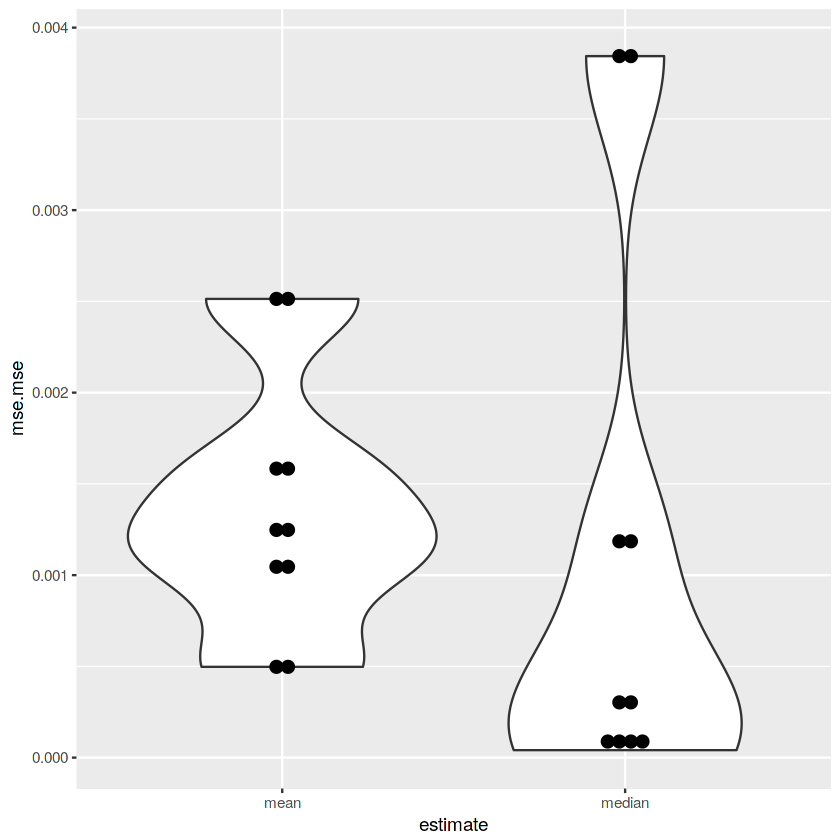

In [7]:
library(ggplot2)
p <- ggplot(data.frame(dat1), aes(x=estimate, y=mse.mse)) + 
    geom_violin() +
    geom_dotplot(binaxis='y', stackdir='center', dotsize = .5)
p